In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

from src.const import SEED
from src.evaluation import eval_acc_in_binary_task
from src.preprocess import transform_to_data_loader
from src.preprocess_utils import create_binary_labels
from src.train import train_model
from src.visualization import plot_conf_matrix, plot_losses

In [2]:
CLASSES = ['known', 'unknown']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load data

In [4]:
X_train = np.load('data/arrays/X_train.npy')
y_train = np.load('data/arrays/y_train.npy')
X_val = np.load('data/arrays/X_val.npy')
y_val = np.load('data/arrays/y_val.npy')
X_test = np.load('data/arrays/X_test.npy')
y_test = np.load('data/arrays/y_test.npy')

Transform labels for binary task

In [5]:
y_train = create_binary_labels(y_train)
y_val = create_binary_labels(y_val)
y_test = create_binary_labels(y_test)

Generate data loaders for train and validation

In [92]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

In [7]:
# Binary task with transformation

# transform = MFCC(sample_rate=16000, n_mfcc=10, melkwargs={"n_fft": 400, "hop_length": 40, "n_mels": 20, "center": False})
# X_tensor = torch.from_numpy(X)

# indices = [i for i in range(0, X_tensor.shape[0], 5000)]
# indices.append(X_tensor.shape[0])

# X_transformed = transform(X_tensor[indices[0]:indices[1]])
# for i in range(1, len(indices)-1):
#     X_transformed = np.concatenate((X_transformed, transform(X_tensor[indices[i]:indices[i+1]]).numpy()), 0)

# # X_transformed_bin = X_transformed

# #Normalizing the MFCC values.
# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = scaler.fit(X_transformed)
# X_normalized = scaler.transform(X_transformed)

# y_bin = create_binary_labels(y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_normalized, y_bin, test_size=0.2, random_state=222
# )

# del X_transformed, X_normalized, y_bin

In [8]:
for x, y in train_dl:
    print(f'Input size: {x.shape}')
    print(f'Labels size: {y.shape}')
    break

Input size: torch.Size([128, 99, 20])
Labels size: torch.Size([128])


## Models

### Transformer

In [9]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, dropout_rate=0.3, units=512):
        
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True, activation="relu").to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(d_model, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [10]:
d_model = 20
n_head = 4
num_layers = 4

transformer_model = Transformer(d_model, n_head, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(transformer_model.parameters(), weight_decay=1e-5)

c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [11]:
summary(transformer_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [128, 1]                  85,748
├─TransformerEncoder: 1-1                     [128, 99, 20]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 99, 20]             85,748
│    │    └─TransformerEncoderLayer: 3-2      [128, 99, 20]             85,748
│    │    └─TransformerEncoderLayer: 3-3      [128, 99, 20]             85,748
│    │    └─TransformerEncoderLayer: 3-4      [128, 99, 20]             85,748
├─Dropout: 1-2                                [128, 20]                 --
├─BatchNorm1d: 1-3                            [128, 20]                 40
├─Linear: 1-4                                 [128, 512]                10,752
├─Dropout: 1-5                                [128, 512]                --
├─ReLU: 1-6                                   [128, 512]               

In [12]:
train_losses, val_losses = train_model(
    model=transformer_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


Epoch 1/50, Train Loss: 0.5563, Train Acc: 0.71, Val Loss: 0.4676, Val Acc: 0.77


Epoch 2: 100%|██████████| 400/400 [00:19<00:00, 20.25it/s]


Epoch 2/50, Train Loss: 0.4149, Train Acc: 0.81, Val Loss: 0.3854, Val Acc: 0.83


Epoch 3: 100%|██████████| 400/400 [00:17<00:00, 22.26it/s]


Epoch 3/50, Train Loss: 0.3621, Train Acc: 0.84, Val Loss: 0.3487, Val Acc: 0.85


Epoch 4: 100%|██████████| 400/400 [00:17<00:00, 22.28it/s]


Epoch 4/50, Train Loss: 0.3249, Train Acc: 0.86, Val Loss: 0.3367, Val Acc: 0.86


Epoch 5: 100%|██████████| 400/400 [00:18<00:00, 22.18it/s]


Epoch 5/50, Train Loss: 0.3040, Train Acc: 0.87, Val Loss: 0.2950, Val Acc: 0.88


Epoch 6: 100%|██████████| 400/400 [00:18<00:00, 22.17it/s]


Epoch 6/50, Train Loss: 0.2814, Train Acc: 0.88, Val Loss: 0.3197, Val Acc: 0.86


Epoch 7: 100%|██████████| 400/400 [00:18<00:00, 22.19it/s]


Epoch 7/50, Train Loss: 0.2670, Train Acc: 0.89, Val Loss: 0.3224, Val Acc: 0.86


Epoch 8: 100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


Epoch 8/50, Train Loss: 0.2539, Train Acc: 0.89, Val Loss: 0.2746, Val Acc: 0.88


Epoch 9: 100%|██████████| 400/400 [00:18<00:00, 22.13it/s]


Epoch 9/50, Train Loss: 0.2407, Train Acc: 0.90, Val Loss: 0.2671, Val Acc: 0.89


Epoch 10: 100%|██████████| 400/400 [00:18<00:00, 22.16it/s]


Epoch 10/50, Train Loss: 0.2298, Train Acc: 0.90, Val Loss: 0.2538, Val Acc: 0.90


Epoch 11: 100%|██████████| 400/400 [00:18<00:00, 22.17it/s]


Epoch 11/50, Train Loss: 0.2185, Train Acc: 0.91, Val Loss: 0.2704, Val Acc: 0.89


Epoch 12: 100%|██████████| 400/400 [00:18<00:00, 21.72it/s]


Epoch 12/50, Train Loss: 0.2122, Train Acc: 0.91, Val Loss: 0.2599, Val Acc: 0.90


Epoch 13: 100%|██████████| 400/400 [00:18<00:00, 21.90it/s]


Epoch 13/50, Train Loss: 0.2004, Train Acc: 0.92, Val Loss: 0.2363, Val Acc: 0.90


Epoch 14: 100%|██████████| 400/400 [00:18<00:00, 22.19it/s]


Epoch 14/50, Train Loss: 0.1973, Train Acc: 0.92, Val Loss: 0.2450, Val Acc: 0.91


Epoch 15: 100%|██████████| 400/400 [00:18<00:00, 22.17it/s]


Epoch 15/50, Train Loss: 0.1889, Train Acc: 0.92, Val Loss: 0.2613, Val Acc: 0.90


Epoch 16: 100%|██████████| 400/400 [00:18<00:00, 22.22it/s]


Epoch 16/50, Train Loss: 0.1823, Train Acc: 0.93, Val Loss: 0.2392, Val Acc: 0.91
Early stopping


#### Evaluation

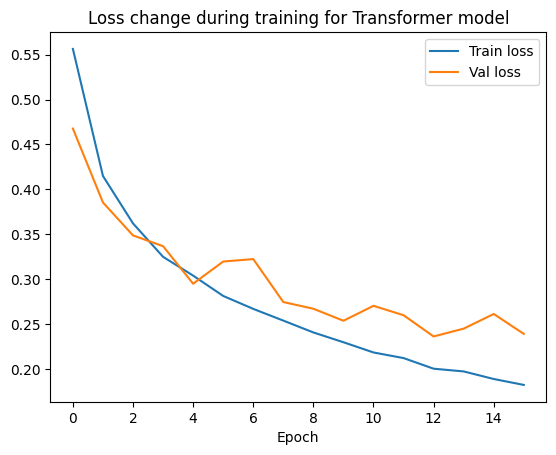

In [13]:
plot_losses(train_losses, val_losses, "Loss change during training for Transformer model")

In [ ]:
eval_acc_in_binary_task(transformer_model, X_train, y_train, 'Train', device)
eval_acc_in_binary_task(transformer_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(transformer_model, X_test, y_test, 'Test', device)

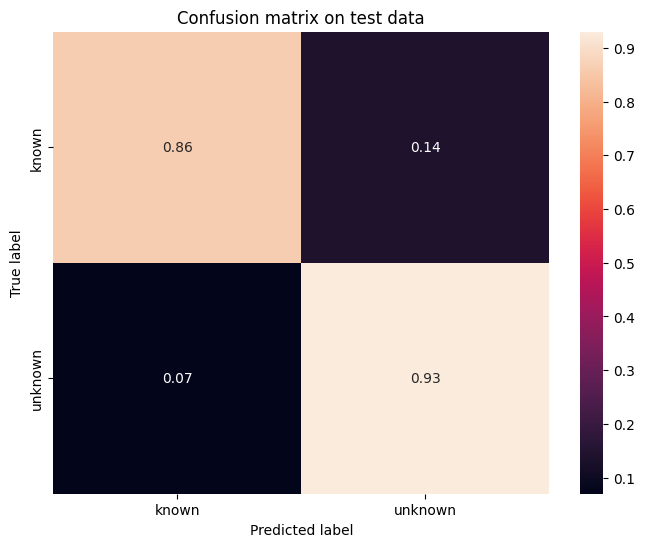

In [20]:
plot_conf_matrix(y_test, y_pred, CLASSES)

### GRU

In [160]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=512, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.gru(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [124]:
input_size = 20
hidden_size = 64
num_layers = 4

gru_model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), weight_decay=1e-5)

In [125]:
summary(gru_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 1]                  --
├─GRU: 1-1                               [128, 99, 64]             91,392
├─Dropout: 1-2                           [128, 64]                 --
├─BatchNorm1d: 1-3                       [128, 64]                 128
├─Linear: 1-4                            [128, 512]                33,280
├─Dropout: 1-5                           [128, 512]                --
├─ReLU: 1-6                              [128, 512]                --
├─BatchNorm1d: 1-7                       [128, 512]                1,024
├─Linear: 1-8                            [128, 1]                  513
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
Total mult-adds (G): 1.16
Input size (MB): 1.01
Forward/backward pass size (MB): 7.60
Params size (MB): 0.51
Estimated Total Size (MB): 9.12

In [126]:
train_losses, val_losses = train_model(
    model=gru_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 400/400 [00:03<00:00, 119.34it/s]


Epoch 1/50, Train Loss: 0.6268, Train Acc: 0.65, Val Loss: 0.5171, Val Acc: 0.74


Epoch 2: 100%|██████████| 400/400 [00:03<00:00, 125.37it/s]


Epoch 2/50, Train Loss: 0.4517, Train Acc: 0.78, Val Loss: 0.3553, Val Acc: 0.84


Epoch 3: 100%|██████████| 400/400 [00:03<00:00, 127.70it/s]


Epoch 3/50, Train Loss: 0.2896, Train Acc: 0.88, Val Loss: 0.2474, Val Acc: 0.90


Epoch 4: 100%|██████████| 400/400 [00:03<00:00, 131.66it/s]


Epoch 4/50, Train Loss: 0.2209, Train Acc: 0.91, Val Loss: 0.3017, Val Acc: 0.87


Epoch 5: 100%|██████████| 400/400 [00:02<00:00, 134.42it/s]


Epoch 5/50, Train Loss: 0.1861, Train Acc: 0.93, Val Loss: 0.2027, Val Acc: 0.92


Epoch 6: 100%|██████████| 400/400 [00:02<00:00, 135.06it/s]


Epoch 6/50, Train Loss: 0.1632, Train Acc: 0.94, Val Loss: 0.1554, Val Acc: 0.94


Epoch 7: 100%|██████████| 400/400 [00:02<00:00, 133.48it/s]


Epoch 7/50, Train Loss: 0.1507, Train Acc: 0.94, Val Loss: 0.1902, Val Acc: 0.92


Epoch 8: 100%|██████████| 400/400 [00:02<00:00, 134.56it/s]


Epoch 8/50, Train Loss: 0.1380, Train Acc: 0.95, Val Loss: 0.1372, Val Acc: 0.94


Epoch 9: 100%|██████████| 400/400 [00:02<00:00, 140.64it/s]


Epoch 9/50, Train Loss: 0.1275, Train Acc: 0.95, Val Loss: 0.1336, Val Acc: 0.95


Epoch 10: 100%|██████████| 400/400 [00:02<00:00, 137.22it/s]


Epoch 10/50, Train Loss: 0.1184, Train Acc: 0.95, Val Loss: 0.1498, Val Acc: 0.94


Epoch 11: 100%|██████████| 400/400 [00:02<00:00, 138.84it/s]


Epoch 11/50, Train Loss: 0.1122, Train Acc: 0.96, Val Loss: 0.1211, Val Acc: 0.95


Epoch 12: 100%|██████████| 400/400 [00:02<00:00, 140.76it/s]


Epoch 12/50, Train Loss: 0.1060, Train Acc: 0.96, Val Loss: 0.1568, Val Acc: 0.94


Epoch 13: 100%|██████████| 400/400 [00:02<00:00, 141.09it/s]


Epoch 13/50, Train Loss: 0.0997, Train Acc: 0.96, Val Loss: 0.1182, Val Acc: 0.95


Epoch 14: 100%|██████████| 400/400 [00:02<00:00, 141.99it/s]


Epoch 14/50, Train Loss: 0.0929, Train Acc: 0.96, Val Loss: 0.1235, Val Acc: 0.95


Epoch 15: 100%|██████████| 400/400 [00:02<00:00, 141.27it/s]


Epoch 15/50, Train Loss: 0.0875, Train Acc: 0.97, Val Loss: 0.1175, Val Acc: 0.95


Epoch 16: 100%|██████████| 400/400 [00:02<00:00, 142.00it/s]


Epoch 16/50, Train Loss: 0.0833, Train Acc: 0.97, Val Loss: 0.1174, Val Acc: 0.95


Epoch 17: 100%|██████████| 400/400 [00:02<00:00, 139.74it/s]


Epoch 17/50, Train Loss: 0.0780, Train Acc: 0.97, Val Loss: 0.1072, Val Acc: 0.96


Epoch 18: 100%|██████████| 400/400 [00:02<00:00, 141.22it/s]


Epoch 18/50, Train Loss: 0.0741, Train Acc: 0.97, Val Loss: 0.1129, Val Acc: 0.96


Epoch 19: 100%|██████████| 400/400 [00:02<00:00, 142.63it/s]


Epoch 19/50, Train Loss: 0.0721, Train Acc: 0.97, Val Loss: 0.1044, Val Acc: 0.96


Epoch 20: 100%|██████████| 400/400 [00:02<00:00, 141.94it/s]


Epoch 20/50, Train Loss: 0.0665, Train Acc: 0.97, Val Loss: 0.1098, Val Acc: 0.96


Epoch 21: 100%|██████████| 400/400 [00:02<00:00, 138.60it/s]


Epoch 21/50, Train Loss: 0.0629, Train Acc: 0.98, Val Loss: 0.1456, Val Acc: 0.95


Epoch 22: 100%|██████████| 400/400 [00:02<00:00, 141.66it/s]


Epoch 22/50, Train Loss: 0.0616, Train Acc: 0.98, Val Loss: 0.1390, Val Acc: 0.96
Early stopping


#### Evaluation

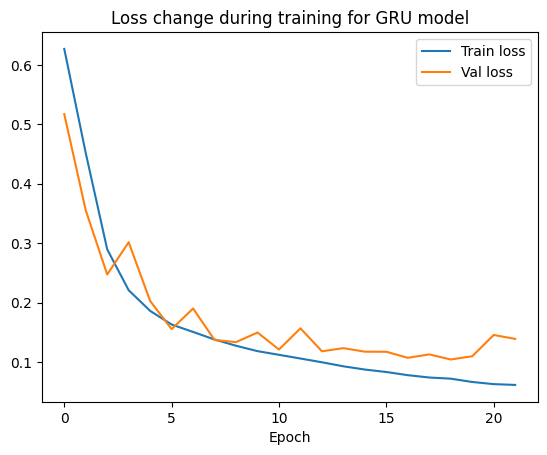

In [127]:
plot_losses(train_losses, val_losses, "Loss change during training for GRU model")

In [149]:
eval_acc_in_binary_task(gru_model, X_train, y_train, 'Train', device)
eval_acc_in_binary_task(gru_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(gru_model, X_test, y_test, 'Test', device)

Test accuracy: 0.9550


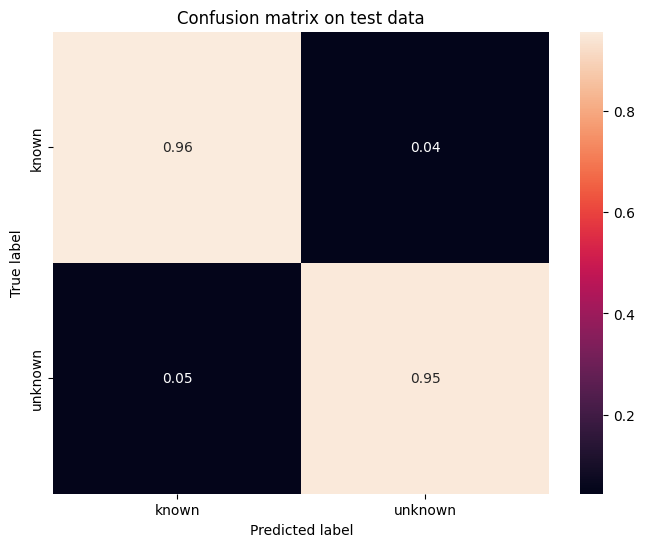

In [150]:
plot_conf_matrix(y_test, y_pred, CLASSES)

### BI-LSTM

In [151]:
class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=512, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2*hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [152]:
input_size = 20
hidden_size = 32
num_layers = 4

bilstm_model = BiLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), weight_decay=1e-5)

In [153]:
summary(bilstm_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 1]                  --
├─LSTM: 1-1                              [128, 99, 64]             89,088
├─Dropout: 1-2                           [128, 64]                 --
├─BatchNorm1d: 1-3                       [128, 64]                 128
├─Linear: 1-4                            [128, 512]                33,280
├─Dropout: 1-5                           [128, 512]                --
├─ReLU: 1-6                              [128, 512]                --
├─BatchNorm1d: 1-7                       [128, 512]                1,024
├─Linear: 1-8                            [128, 1]                  513
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 124,033
Trainable params: 124,033
Non-trainable params: 0
Total mult-adds (G): 1.13
Input size (MB): 1.01
Forward/backward pass size (MB): 7.60
Params size (MB): 0.50
Estimated Total Size (MB): 9.11

In [154]:
train_losses, val_losses = train_model(
    model=bilstm_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 400/400 [00:03<00:00, 118.83it/s]


Epoch 1/50, Train Loss: 0.6320, Train Acc: 0.64, Val Loss: 0.5651, Val Acc: 0.69


Epoch 2: 100%|██████████| 400/400 [00:03<00:00, 124.39it/s]


Epoch 2/50, Train Loss: 0.5145, Train Acc: 0.74, Val Loss: 0.5603, Val Acc: 0.74


Epoch 3: 100%|██████████| 400/400 [00:03<00:00, 128.00it/s]


Epoch 3/50, Train Loss: 0.4375, Train Acc: 0.79, Val Loss: 0.4215, Val Acc: 0.80


Epoch 4: 100%|██████████| 400/400 [00:03<00:00, 127.05it/s]


Epoch 4/50, Train Loss: 0.3808, Train Acc: 0.83, Val Loss: 0.3582, Val Acc: 0.84


Epoch 5: 100%|██████████| 400/400 [00:03<00:00, 130.48it/s]


Epoch 5/50, Train Loss: 0.3142, Train Acc: 0.86, Val Loss: 0.2902, Val Acc: 0.88


Epoch 6: 100%|██████████| 400/400 [00:03<00:00, 128.46it/s]


Epoch 6/50, Train Loss: 0.2669, Train Acc: 0.89, Val Loss: 0.2490, Val Acc: 0.90


Epoch 7: 100%|██████████| 400/400 [00:03<00:00, 129.05it/s]


Epoch 7/50, Train Loss: 0.2380, Train Acc: 0.90, Val Loss: 0.2279, Val Acc: 0.91


Epoch 8: 100%|██████████| 400/400 [00:03<00:00, 130.41it/s]


Epoch 8/50, Train Loss: 0.2092, Train Acc: 0.92, Val Loss: 0.2076, Val Acc: 0.92


Epoch 9: 100%|██████████| 400/400 [00:02<00:00, 134.10it/s]


Epoch 9/50, Train Loss: 0.1873, Train Acc: 0.93, Val Loss: 0.2043, Val Acc: 0.91


Epoch 10: 100%|██████████| 400/400 [00:03<00:00, 130.99it/s]


Epoch 10/50, Train Loss: 0.1790, Train Acc: 0.93, Val Loss: 0.1729, Val Acc: 0.93


Epoch 11: 100%|██████████| 400/400 [00:02<00:00, 138.32it/s]


Epoch 11/50, Train Loss: 0.1649, Train Acc: 0.94, Val Loss: 0.2143, Val Acc: 0.92


Epoch 12: 100%|██████████| 400/400 [00:02<00:00, 145.39it/s]


Epoch 12/50, Train Loss: 0.1536, Train Acc: 0.94, Val Loss: 0.1737, Val Acc: 0.94


Epoch 13: 100%|██████████| 400/400 [00:02<00:00, 145.45it/s]


Epoch 13/50, Train Loss: 0.1462, Train Acc: 0.94, Val Loss: 0.1723, Val Acc: 0.93


Epoch 14: 100%|██████████| 400/400 [00:02<00:00, 141.10it/s]


Epoch 14/50, Train Loss: 0.1379, Train Acc: 0.95, Val Loss: 0.1450, Val Acc: 0.94


Epoch 15: 100%|██████████| 400/400 [00:02<00:00, 145.41it/s]


Epoch 15/50, Train Loss: 0.1316, Train Acc: 0.95, Val Loss: 0.1414, Val Acc: 0.94


Epoch 16: 100%|██████████| 400/400 [00:02<00:00, 145.65it/s]


Epoch 16/50, Train Loss: 0.1222, Train Acc: 0.95, Val Loss: 0.1349, Val Acc: 0.95


Epoch 17: 100%|██████████| 400/400 [00:02<00:00, 141.35it/s]


Epoch 17/50, Train Loss: 0.1190, Train Acc: 0.95, Val Loss: 0.1237, Val Acc: 0.95


Epoch 18: 100%|██████████| 400/400 [00:02<00:00, 144.25it/s]


Epoch 18/50, Train Loss: 0.1120, Train Acc: 0.96, Val Loss: 0.1316, Val Acc: 0.95


Epoch 19: 100%|██████████| 400/400 [00:02<00:00, 143.10it/s]


Epoch 19/50, Train Loss: 0.1065, Train Acc: 0.96, Val Loss: 0.1354, Val Acc: 0.95


Epoch 20: 100%|██████████| 400/400 [00:02<00:00, 141.42it/s]


Epoch 20/50, Train Loss: 0.1018, Train Acc: 0.96, Val Loss: 0.1320, Val Acc: 0.95
Early stopping


#### Evaluation

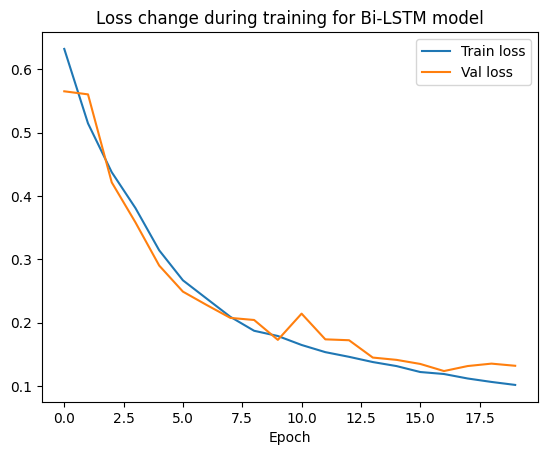

In [158]:
plot_losses(train_losses, val_losses, "Loss change during training for Bi-LSTM model")

In [156]:
eval_acc_in_binary_task(bilstm_model, X_train, y_train, 'Train', device)
eval_acc_in_binary_task(bilstm_model, X_val, y_val, 'Validation', device)
y_pred, acc = eval_acc_in_binary_task(bilstm_model, X_test, y_test, 'Test', device)

Test accuracy: 0.9409


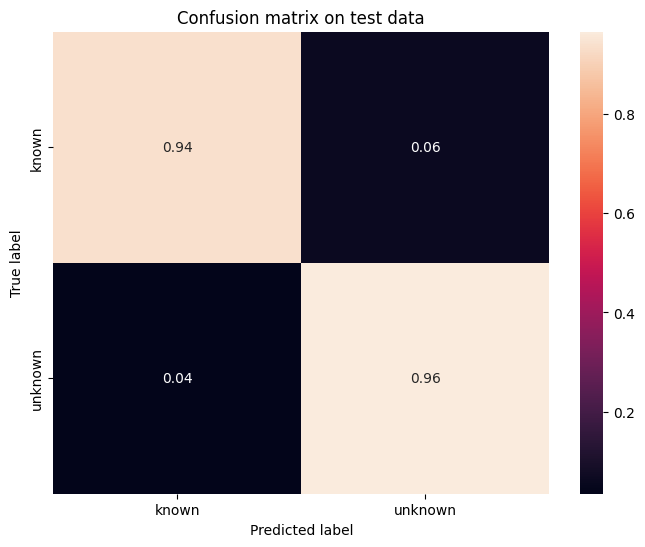

In [159]:
plot_conf_matrix(y_test, y_pred, CLASSES)